In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Counterfactual explanations for the GSMarena dataset

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [30]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


In [31]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [149]:
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.util_base_cf import inverse_pipeline

In [33]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [34]:
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

Unique values in the train dataset for discrete features

In [35]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
df_train_post = inverse_pipeline(cols_pipeline, df_train)

discrete_features = df_train_post.columns.drop(["misc_price_min", "misc_price_max", "display_size", "battery"])
print(f"Discrete features: {discrete_features.tolist()}")
for c in discrete_features:
    c_series = df_train_post[c].copy()
    try:
        c_series = c_series.astype(float)
        c_series = c_series.round(2)
    except ValueError:
        c_series = c_series.astype(str)

    print(f"'{c}' unique values: {np.sort(c_series.unique())}")

Discrete features: ['memory_ram_gb', 'memory_rom_gb', 'main_camera_resolution', 'selfie_camera_resolution', 'display_resolution', 'network_technology', 'num_main_camera', 'has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers', 'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'has_wireless_charging', 'is_waterproof']
'memory_ram_gb' unique values: [ 1.   1.5  2.   3.   4.   6.   8.  10.  12. ]
'memory_rom_gb' unique values: [  4.   8.  16.  32.  64. 128. 256.]
'main_camera_resolution' unique values: [  3.   4.   5.   7.   9.  11.  12.  13.  14.  16.  18.  19.  20.  22.
  24.  26.  32.  41.  48.  50.  64. 108.]
'selfie_camera_resolution' unique values: [ 1.  3.  4.  5.  6.  7.  9. 11. 12. 13. 16. 20. 24. 26. 32. 41. 44.]
'display_resolution' unique values: ['FHD' 'HD' 'QHD' 'qHD']
'network_technology' unique values: ['3G' '4G' '5G']
'num_main_camera' unique values: [1. 2. 3. 4.]
'has_oled_display' unique values: [0. 1.]
'has_memory_card_slot' unique values: [0. 1.]
'has_stereo_sp

## Evaluation on multi-class classification

In [36]:
def change_dataframe(df, label: int):
    df = df.copy()
    df = df.T
    df.insert(0, "misc_price", label)
    return df

In [37]:
concat_df = pd.DataFrame()
for cf_label, file_name in zip([1, 0, 2, 1], ["low_to_medium", "medium_to_low", "medium_to_high", "high_to_medium"]):
    print(f"CF label: {cf_label}")
    print(f"File name: {file_name}")
    df = pd.read_csv(f"data/counterfactual/{file_name}.old.csv", index_col=0)
    df = change_dataframe(df, cf_label)

    concat_df = pd.concat([concat_df, df], axis=0)

# String features
string_features = ["display_resolution", "network_technology"]
print(f"String features: {string_features}")
concat_df[string_features] = concat_df[string_features].astype(str)

# Decimal features
decimal_features = ["display_size", "battery"]
print(f"Decimal features: {decimal_features}")
# Cast float features and round to 1 decimal
concat_df[decimal_features] = concat_df[decimal_features].astype(float).round(2)

# Memory features
memory_features = ["memory_ram_gb"]
print(f"Memory features: {memory_features}")
concat_df[memory_features] = concat_df[memory_features].astype(float).round(1)

# Ordinal features
ordinal_features = concat_df.columns[concat_df.columns.str.startswith("has_") | concat_df.columns.str.startswith("is_")]
print(f"Ordinal features: {ordinal_features}")
concat_df[ordinal_features] = concat_df[ordinal_features].astype(float).round(0).astype(int)

# Float features
float_features = concat_df.columns.difference(ordinal_features.tolist() + decimal_features + string_features + memory_features)
print(f"Float features: {float_features}")
concat_df[float_features] = concat_df[float_features].astype(float).round(0)

# Save to csv
concat_df.to_csv("data/counterfactual/multiclass.csv")

CF label: 1
File name: low_to_medium
CF label: 0
File name: medium_to_low
CF label: 2
File name: medium_to_high
CF label: 1
File name: high_to_medium
String features: ['display_resolution', 'network_technology']
Decimal features: ['display_size', 'battery']
Memory features: ['memory_ram_gb']
Ordinal features: Index(['has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers',
       'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'has_wireless_charging',
       'is_waterproof'],
      dtype='object')
Float features: Index(['main_camera_resolution', 'memory_rom_gb', 'misc_price',
       'misc_price_max', 'misc_price_min', 'num_main_camera',
       'selfie_camera_resolution'],
      dtype='object')


Read the counterfactual dataset (on the test set) 

In [38]:
df_cf = pd.read_csv("data/counterfactual/multiclass.csv", index_col=0)
df_cf.head()

,misc_price,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
664,1.0,215.0,420.0,6.37,2333.24,4.0,32.0,16.0,13.0,HD,4G,1.0,0,1,0,1,0,0,0,0
1228,1.0,215.0,420.0,6.09,2333.24,2.0,64.0,12.0,13.0,qHD,4G,1.0,1,1,0,1,0,0,0,0
1095,1.0,215.0,420.0,6.37,3436.45,2.0,16.0,12.0,4.0,HD,3G,1.0,1,1,0,1,0,0,0,0
584,1.0,215.0,420.0,4.95,2333.24,2.0,64.0,12.0,12.0,HD,4G,1.0,0,1,0,1,1,1,0,0
120,1.0,215.0,420.0,6.37,4118.63,2.0,16.0,12.0,4.0,HD,4G,2.0,1,1,0,1,0,0,0,1


Read the original test dataset and compute the features in the original space

In [39]:
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)
df_test_post = inverse_pipeline(cols_pipeline, df_test)
df_test_post["num_main_camera"] = df_test_post["num_main_camera"].astype(float).round(0)
df_test_post.head()

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.30,4050.0,4.0,64.0,26.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1
1861,215.0,420.0,5.50,3000.0,3.0,32.0,16.0,9.0,QHD,4G,1.0,1,1,1,1,1,1,0,0
1339,215.0,420.0,6.00,3500.0,4.0,32.0,16.0,16.0,FHD,4G,1.0,1,1,0,1,1,1,0,1
664,40.0,215.0,6.09,3020.0,3.0,64.0,13.0,9.0,FHD,4G,1.0,0,1,0,1,0,0,0,0
918,215.0,420.0,5.00,2420.0,3.0,32.0,13.0,9.0,FHD,4G,1.0,0,1,0,1,1,0,0,0


In [40]:
idx = [664, 1228]
sub_test = df_test_post.loc[idx]
sub_cf = df_cf.loc[idx]

In [46]:
def join_merge_columns(df_cf, df_original):
    columns = df_original.columns
    lsuffix, rsuffix = "_cf", "_original"

    inner_df = df_cf.join(df_original, how="inner", lsuffix=lsuffix, rsuffix=rsuffix)
    display(inner_df)
    for c in columns:
        left_c = c + lsuffix
        right_c = c + rsuffix
        if inner_df[left_c].dtype != inner_df[right_c].dtype:
            raise ValueError(f"Column '{c}' has different dtypes: {inner_df[left_c].dtype} and {inner_df[right_c].dtype}")
        equal_values = inner_df[left_c] == (inner_df[right_c])
        assert isinstance(equal_values, pd.Series)

        if equal_values.any():
            inner_df.loc[equal_values, left_c] = np.nan 
    
    return inner_df

merge_df = join_merge_columns(df_cf, df_test_post)

,misc_price,misc_price_min_cf,misc_price_max_cf,display_size_cf,battery_cf,memory_ram_gb_cf,memory_rom_gb_cf,main_camera_resolution_cf,selfie_camera_resolution_cf,display_resolution_cf,...,network_technology_original,num_main_camera_original,has_oled_display_original,has_memory_card_slot_original,has_stereo_speakers_original,has_3.5mm_jack_original,has_wlan_5ghz_original,has_nfc_original,has_wireless_charging_original,is_waterproof_original
31,0.0,40.0,215.0,6.20,3092.31,4.0,16.0,16.0,13.0,HD,...,5G,3.0,0,0,0,1,1,0,0,0
31,2.0,420.0,1600.0,6.37,3711.25,4.0,16.0,16.0,13.0,HD,...,5G,3.0,0,0,0,1,1,0,0,0
33,1.0,215.0,420.0,6.37,3854.08,4.0,64.0,16.0,13.0,HD,...,4G,4.0,1,0,0,0,1,1,1,1
40,0.0,40.0,215.0,6.28,4118.60,3.0,64.0,16.0,12.0,HD,...,4G,4.0,0,0,0,1,1,1,0,0
40,2.0,420.0,1600.0,5.62,3616.34,4.0,64.0,17.0,13.0,HD,...,4G,4.0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2.0,420.0,1600.0,6.37,3425.07,3.0,64.0,17.0,13.0,HD,...,4G,3.0,1,0,0,1,1,1,0,0
1893,1.0,215.0,420.0,6.37,3031.11,4.0,64.0,14.0,8.0,qHD,...,4G,3.0,1,0,0,0,1,1,0,0
1899,1.0,215.0,420.0,6.03,4118.63,4.0,64.0,16.0,14.0,qHD,...,5G,4.0,1,0,0,1,1,1,0,0
1900,0.0,40.0,215.0,5.59,3957.06,4.0,64.0,16.0,13.0,HD,...,4G,4.0,1,1,0,1,1,0,0,0


Count the number of changed features

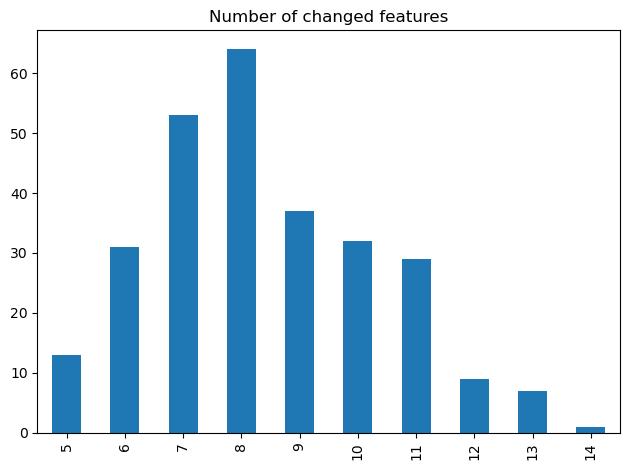

In [100]:
def count_changed_features(series, num_features):
    return num_features - series.isna().sum()


num_changed = merge_df.apply(lambda x: count_changed_features(x, 17), axis=1)
num_changed.value_counts().sort_index().plot.bar(title="Number of changed features")
plt.tight_layout()

In [168]:
num_changed = merge_df.apply(lambda x: count_changed_features(x, 17), axis=1)
least_changed = num_changed[num_changed < 7].index

df_test_raw = pd.read_csv("data/processed/gsm_test.csv", index_col=0)
price_least_changed =df_test_raw.loc[least_changed]["misc_price"]
price_least_changed[(210 <= price_least_changed) & (price_least_changed <= 420)].mean()

291.80947368421056

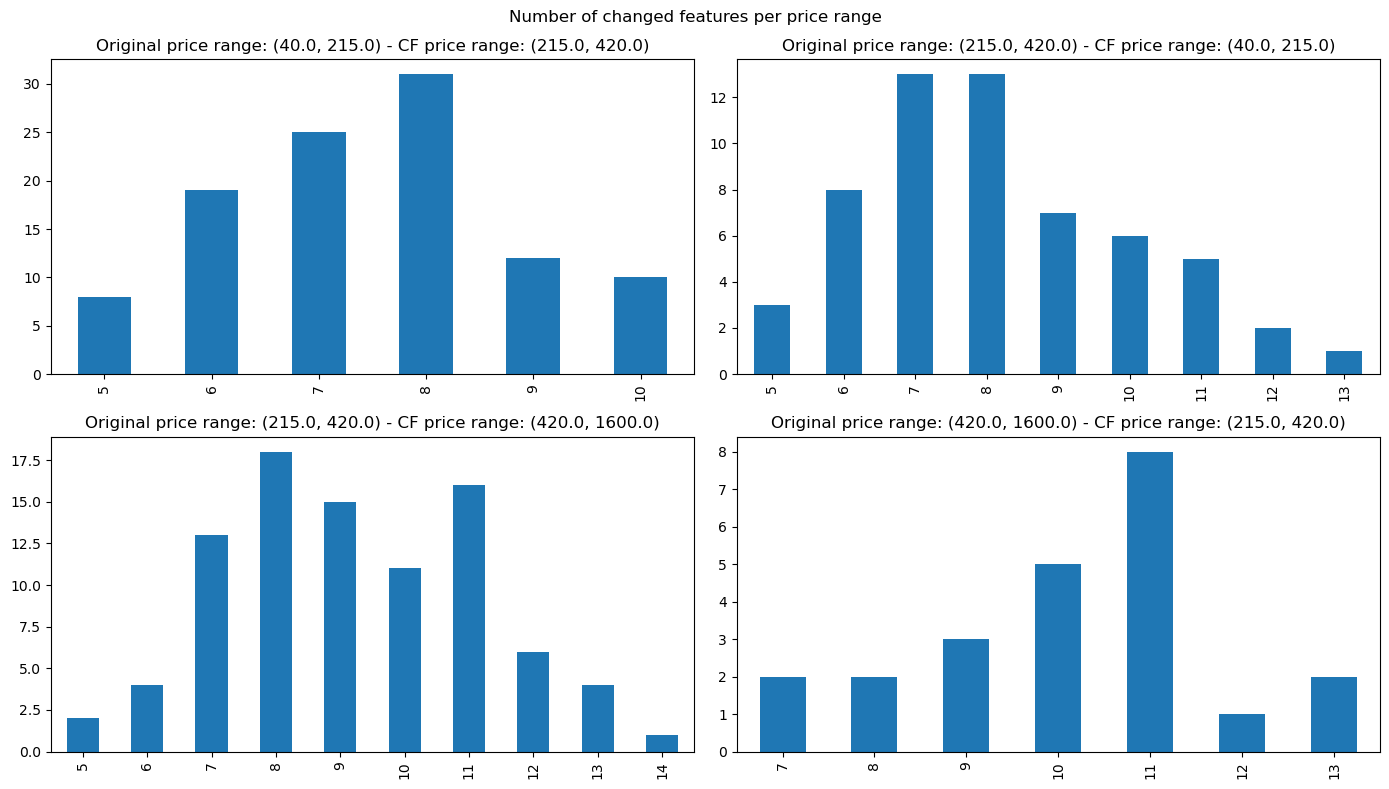

In [104]:
assert isinstance(merge_df, pd.DataFrame)
grouped_df = merge_df.groupby(['misc_price_min_original', 'misc_price_min_cf'], axis=0)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
faxs = axs.ravel()

for i, (name, group) in enumerate(grouped_df):
    original_price = (group["misc_price_min_original"].unique().item(), group["misc_price_max_original"].unique().item())
    assert len(original_price) == 2
    cf_price = (group["misc_price_min_cf"].unique().item(), group["misc_price_max_cf"].unique().item())
    assert len(cf_price) == 2

    num_changed = group.apply(lambda x: count_changed_features(x, 17), axis=1)
    num_changed.value_counts().sort_index().plot.bar(ax=faxs[i], title=f"Original price range: {original_price} - CF price range: {cf_price}")


fig.suptitle("Number of changed features per price range")
fig.tight_layout()

The type of features that have been changed the most

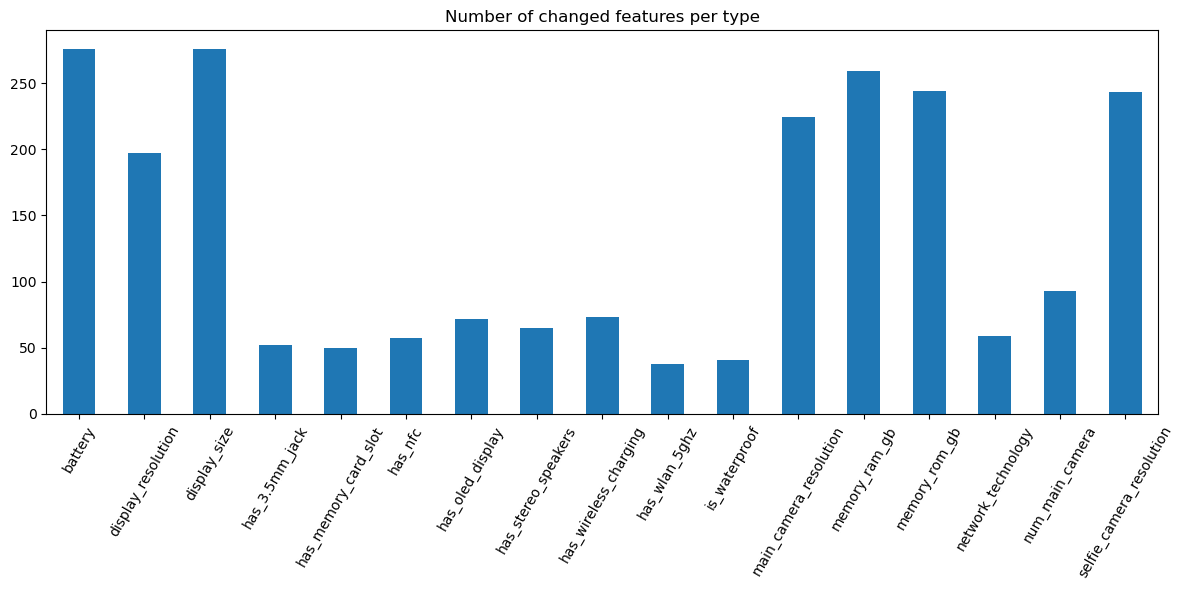

In [141]:
def count_type_features(series, columns: pd.Index):
    na_columns = series[series.isna()].index
    assert isinstance(na_columns, pd.Index)
    na_columns = na_columns.str.removesuffix("_cf")
    return columns.difference(na_columns).to_numpy()


feature_columns = df_test_post.columns.drop(["misc_price_min", "misc_price_max"])
features_changed = Counter(np.concatenate(merge_df.apply(count_type_features, columns=feature_columns, axis=1).values))
features_changed = pd.Series(features_changed).sort_index()
features_changed.plot.bar(title="Number of changed features per type", rot=60, figsize=(12, 6))
plt.tight_layout()

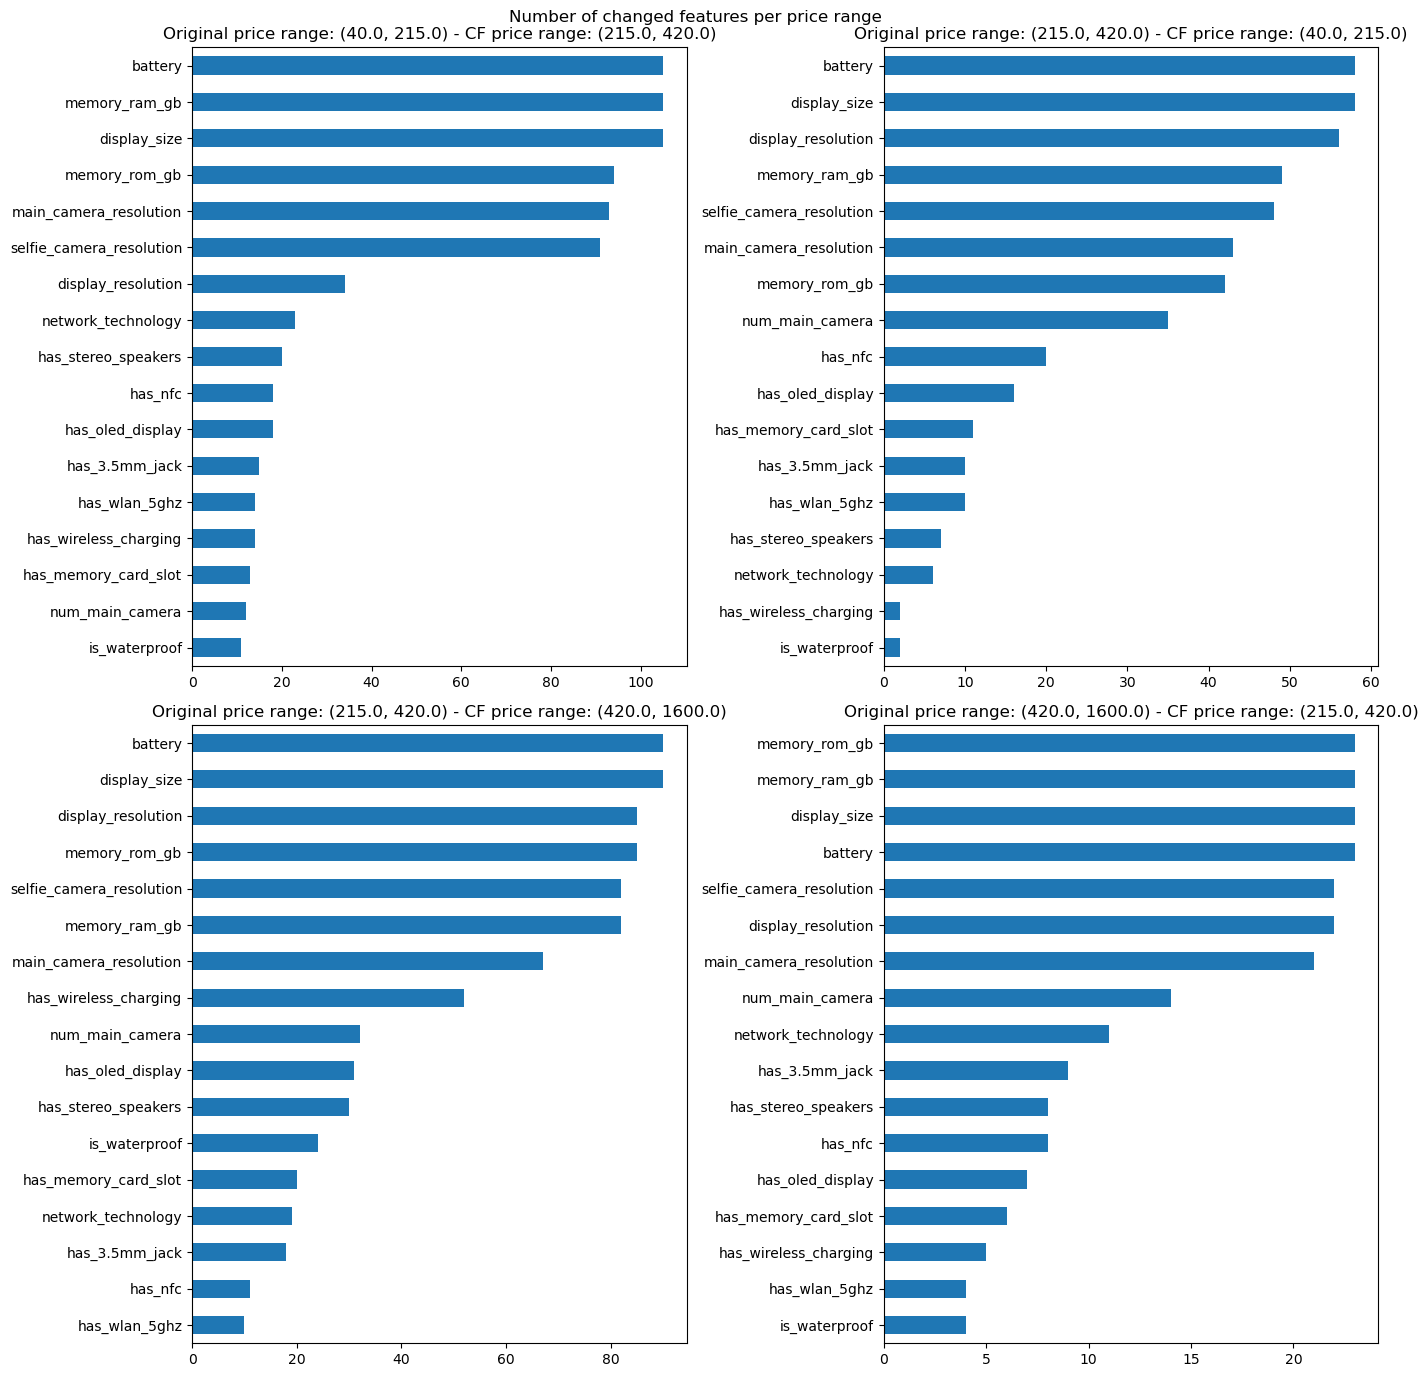

In [148]:
assert isinstance(merge_df, pd.DataFrame)
grouped_df = merge_df.groupby(['misc_price_min_original', 'misc_price_min_cf'], axis=0)
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
faxs = axs.ravel()

feature_columns = df_test_post.columns.drop(["misc_price_min", "misc_price_max"])

for i, (name, group) in enumerate(grouped_df):
    original_price = (group["misc_price_min_original"].unique().item(), group["misc_price_max_original"].unique().item())
    assert len(original_price) == 2
    cf_price = (group["misc_price_min_cf"].unique().item(), group["misc_price_max_cf"].unique().item())
    assert len(cf_price) == 2

    features_changed = Counter(np.concatenate(group.apply(count_type_features, columns=feature_columns, axis=1).values))
    features_changed = pd.Series(features_changed).sort_values()
    features_changed.plot.barh(title=f"Original price range: {original_price} - CF price range: {cf_price}", ax=faxs[i])


fig.suptitle("Number of changed features per price range")
fig.tight_layout()

In [60]:
def show_sample(df, idx):
    sample = df.loc[idx]
    not_changed_cols = []
    assert isinstance(sample, pd.Series)
    for c in sample.index[sample.isna()]:
        prefix_col = c.rsplit("_", 1)[0]
        with_value_col = prefix_col + "_original"
        sample = sample.rename(index={with_value_col: prefix_col})

        not_changed_cols.append(prefix_col)

    df_sample = sample[sample.notna()].sort_index().to_frame()
    return df_sample.style.apply(lambda x: ["background: blue; opacity: 0.50; color: white;" if v not in not_changed_cols else "" for v in x.index], axis=0)

show_sample(merge_df, 919)

,919
battery_cf,3072.040000
battery_original,4100.000000
display_resolution_cf,HD
display_resolution_original,FHD
display_size_cf,5.920000
display_size_original,5.500000
has_3.5mm_jack_cf,0.000000
has_3.5mm_jack_original,1
has_memory_card_slot_cf,1.000000
has_memory_card_slot_original,0
